In [25]:
"""
Run regressions that strip predictable components of consumption and income
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys; sys.path.append('/home/mitch/school/data/mexico_enigh/src/')
sys.path.append('/home/mitch/util/python/')
from stargazer.stargazer import Stargazer

import mpl

import utils
import os

import statsmodels.stats.weightstats as ws

plotdir = '/home/mitch/school/data/mexico_enigh/fig/'

processed = '/home/mitch/Dropbox/data/mexico_enigh/processed/'

save = False


In [26]:
os.chdir(processed)
df = pd.read_csv('data.csv')

df = df.query('Y >= 1994').query('Y <= 1996')
df['post'] = df['Y'] == 1996
df

/tmp/ipykernel_2193021/1874065039.py:2: DtypeWarning: Columns (70,81) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data.csv')


,hhid,location,weight,location_size,ingmon,permon,gasnom,eronom,income_current,gasmon,...,terceros,pago_tar,deudas,monedas,casas,balance,otra_ero,clase_hog,nom_emp,post
0,19940110010,1001,169,1,6480.0,0.0,920.31,1680.0,7400.31,5062.41,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,19940110030,1001,169,1,2760.0,0.0,593.54,0.0,3353.54,2002.79,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,19940110040,1001,169,1,6600.0,0.0,1533.85,0.0,8133.85,4925.66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,19940110060,1001,153,1,7560.0,200.0,1305.79,0.0,8865.79,4109.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,19940110070,1001,153,1,13000.0,500.0,3185.04,0.0,16185.04,11161.73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20541,19963399020,15033,1351,1,4800.0,0.0,306.67,0.0,5106.67,4182.13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
20542,19963399030,15033,1351,1,2950.0,0.0,1257.35,0.0,4207.35,2359.12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
20543,19963399040,15033,1351,1,2650.0,200.0,920.01,0.0,3570.01,2046.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
20544,19963399060,15109,1077,2,5280.0,500.0,3610.95,0.0,8890.95,5860.77,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [27]:
cpidir = '/home/mitch/Dropbox/data/cpi/'
os.chdir(cpidir)
cpi = pd.read_csv('cpi_annual.csv')
cpi = cpi.rename(columns = {'time':'Y', 'PCPI_IX':'cpi'})
cpi = cpi.query('country == "MX"')
cpi = cpi.drop(columns=['Unnamed: 0', 'country'])

In [28]:
df = df.merge(cpi, on='Y', how='inner')

In [29]:
# don't include: other income
# transfers
# rental income

# do include:
# salary income
# business income

is1992 = df['Y'] == 1992

#income = ['salary_income', 'business_income', 'transfers_income']
income = ['income_salary', 'income_business', 'income_transfers']
df['income'] = df[income].sum(axis=1)
df['income'] = df['income'] / df['cpi']
df['income'] = df['income'] / df['hh_size']
df.loc[is1992, 'income'] = df.loc[is1992, 'income'] / 1000
df['log_income'] = np.log(df['income'])

consumption = ['consumption_clothing']
#consumption = ['consumption_food', 'consumption_clothing', 'consumption_personal', 'consumption_education']
df['consumption'] = df[consumption].sum(axis=1)
df['consumption'] = df['consumption'] / df['cpi']
df['consumption'] = df['consumption'] / df['hh_size']
df.loc[is1992, 'consumption'] = df.loc[is1992, 'consumption'] / 1000
df['log_consumption'] = np.log(df['consumption'])

/home/mitch/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/mitch/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [30]:
df = df.query('relationship_to_hhm == 1')
df = df.query('income > 0')
df = df.query('consumption > 0')
df = df.query('age >= 25')
df = df.query('age <= 60')
df = df[df['location_size'].apply(lambda x : x not in [4.0, 5.0])]

In [31]:
consumption_to_income = ws.DescrStatsW(df['consumption'] / df['income'], weights=df['weight'])
consumption_to_income_005 = consumption_to_income.quantile(0.005)
consumption_to_income_995 = consumption_to_income.quantile(0.995)
df = df[df['consumption'] / df['income'] > consumption_to_income_005.values[0]]
df = df[df['consumption'] / df['income'] < consumption_to_income_995.values[0]]

#df['log_income']      = utils.residualize_income(df)
#df['log_consumption'] = utils.residualize_consumption(df)


#df['income'] = df['log_income'].apply(np.exp)
#df['consumption'] = df['log_consumption'].apply(np.exp)

In [32]:
deciles = []
for Y in np.sort(df.Y.unique()):
    data = df.query('Y == @Y')[['hhid', 'income', 'weight']]
    data['decile'] = utils.get_deciles(data['income'], data['weight'])
    data['Y'] = Y
    deciles.append(data)
deciles = pd.concat(deciles)
    

In [33]:
df = df.merge(deciles[['hhid', 'Y', 'decile']], on=['hhid', 'Y'], how='outer')
df

,hhid,location,weight,location_size,ingmon,permon,gasnom,eronom,income_current,gasmon,...,otra_ero,clase_hog,nom_emp,post,cpi,income,log_income,consumption,log_consumption,decile
0,19940110010,1001,169,1,6480.0,0.0,920.31,1680.0,7400.31,5062.41,...,NaN,NaN,NaN,False,19.551304,36.826188,3.606209,4.182728,1.430964,3
1,19940110030,1001,169,1,2760.0,0.0,593.54,0.0,3353.54,2002.79,...,NaN,NaN,NaN,False,19.551304,47.055685,3.851332,3.667275,1.299449,4
2,19940110040,1001,169,1,6600.0,0.0,1533.85,0.0,8133.85,4925.66,...,NaN,NaN,NaN,False,19.551304,56.262232,4.030023,5.225568,1.653563,5
3,19940110070,1001,153,1,13000.0,500.0,3185.04,0.0,16185.04,11161.73,...,NaN,NaN,NaN,False,19.551304,110.819548,4.707903,11.346217,2.428884,8
4,19940110090,1001,153,1,5700.0,950.0,1746.76,0.0,7446.76,4774.50,...,NaN,NaN,NaN,False,19.551304,97.180219,4.576567,4.500979,1.504295,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11274,19963399020,15033,1351,1,4800.0,0.0,306.67,0.0,5106.67,4182.13,...,NaN,NaN,NaN,True,35.467989,33.833325,3.521446,0.498830,-0.695490,4
11275,19963399030,15033,1351,1,2950.0,0.0,1257.35,0.0,4207.35,2359.12,...,NaN,NaN,NaN,True,35.467989,20.793398,3.034636,0.285046,-1.255106,2
11276,19963399040,15033,1351,1,2650.0,200.0,920.01,0.0,3570.01,2046.06,...,NaN,NaN,NaN,True,35.467989,10.673609,2.367774,0.408860,-0.894383,1
11277,19963399060,15109,1077,2,5280.0,500.0,3610.95,0.0,8890.95,5860.77,...,NaN,NaN,NaN,True,35.467989,49.622210,3.904439,2.299444,0.832668,6


In [34]:
params = ['post[T.True]:C(decile)[' + str(x) + ']' for x in np.arange(1, 11) ]

In [35]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.weightstats as ws

from statsmodels.genmod.families.links import identity
fam = sm.families.Gaussian(identity())

In [36]:
#Z = 'age + I(age**2) + C(sex) + C(education) + C(hh_size)  + C(location_size)'
Z = 'age + I(age**2) + C(sex) + C(education) + C(location_size) + C(decile)'
D = 'post:C(decile) + post:C(education) + post:C(sex)'
#D = ' post:C(education) + post:C(sex)'

income_reg = 'log_income ~ ' + Z + '+' + D
#income_reg = 'log_income ~ ' + Z 
#income_model = smf.wls(income_reg, df, weights=df['weight']).fit()
income_model = smf.glm(income_reg, df, freq_weights=df['weight'], missing='drop', family=fam).fit()
#df['log_income_resid'] = income_model.resid

In [37]:
import statsmodels.formula.api as smf
import statsmodels.stats.weightstats as ws
#Z = 'age + I(age**2) + C(sex) + C(education) + C(hh_size)  + C(location_size)'
Z = 'age + I(age**2) + C(sex) + C(education) + C(location_size) + C(decile)'
D = 'post:C(decile) + post:C(education) + post:C(sex)'
#D = 'post:C(education) + post:C(sex)'

consumption_reg = 'log_consumption ~ ' + Z + '+' + D
#income_reg = 'log_consumption ~ ' + Z 
#consumption_model = smf.wls(consumption_reg, df, weights=df['weight']).fit()
consumption_model = smf.glm(consumption_reg, df, freq_weights=df['weight'], missing='drop', family=fam).fit()
#df['log_consumption_resid'] = consumption_model.resid

In [38]:
consumption_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        log_consumption   No. Observations:                11279
Model:                            GLM   Df Residuals:                 20067999
Model Family:                Gaussian   Df Model:                           29
Link Function:               identity   Scale:                         0.81914
Method:                          IRLS   Log-Likelihood:            -2.6474e+07
Date:                Wed, 29 Nov 2023   Deviance:                   1.6439e+07
Time:                        17:06:45   Pearson chi2:                 1.64e+07
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.3196      0.004     78.043      0.000       0.312       0.328
C(sex)[T.2]                             0.1552      0.001    183.698      0.000       0.154       0.157
C(education)[T.low]                    -0.2510      0.001   -249.284      0.000      -0.253      -0.249
C(education)[T.medium]                 -0.0602      0.001    -63.069      0.000      -0.062      -0.058
C(location_size)[T.2]                   0.0395      0.001     71.157      0.000       0.038       0.041
C(location_size)[T.3]                   0.0895      0.001    149.445      0.000       0.088       0.091
C(decile)[T.2]                          0.5531      0.001    410.780      0.000       0.550       0.556
C(decile)[T.3]                          0.7918      0.001    624.077      0.000       0.789       0.794
C(decile)[T.4]                          1.1072      0.001    841.829      0.000       1.105       1.110
C(decile)[T.5]                          1.2365      0.001    931.393      0.000       1.234       1.239
C(decile)[T.6]                          1.5163      0.001   1143.315      0.000       1.514       1.519
C(decile)[T.7]                          1.5992      0.001   1197.920      0.000       1.597       1.602
C(decile)[T.8]                          1.8315      0.001   1343.828      0.000       1.829       1.834
C(decile)[T.9]                          2.2518      0.001   1596.881      0.000       2.249       2.255
C(decile)[T.10]                         2.7289      0.001   1832.481      0.000       2.726       2.732
post[T.True]:C(decile)[1]              -0.3289      0.002   -180.019      0.000      -0.333      -0.325
post[T.True]:C(decile)[2]              -0.5251      0.002   -285.944      0.000      -0.529      -0.521
post[T.True]:C(decile)[3]              -0.4716      0.002   -267.864      0.000      -0.475      -0.468
post[T.True]:C(decile)[4]              -0.6527      0.002   -370.524      0.000      -0.656      -0.649
post[T.True]:C(decile)[5]              -0.5225      0.002   -300.328      0.000      -0.526      -0.519
post[T.True]:C(decile)[6]              -0.5258      0.002   -306.911      0.000      -0.529      -0.522
post[T.True]:C(decile)[7]              -0.3317      0.002   -200.501      0.000      -0.335      -0.328
post[T.True]:C(decile)[8]              -0.3940      0.002   -245.530      0.000      -0.397      -0.391
post[T.True]:C(decile)[9]              -0.4511      0.001   -302.254      0.000      -0.454      -0.448
post[T.True]:C(decile)[10]             -0.3183      0.001   -237.931      0.000      -0.321      -0.316
post[T.True]:C(education)[T.low]        0.0801      0.001     57.814      0.000       0.077       0.083
post[T.True]:C(education)[T.medium]    -0.0689      0.001    -52.15

In [39]:
income_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             log_income   No. Observations:                11279
Model:                            GLM   Df Residuals:                 20067999
Model Family:                Gaussian   Df Model:                           29
Link Function:               identity   Scale:                        0.048319
Method:                          IRLS   Log-Likelihood:             1.9272e+06
Date:                Wed, 29 Nov 2023   Deviance:                   9.6966e+05
Time:                        17:06:45   Pearson chi2:                 9.70e+05
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               2.8185      0.001   2833.363      0.000       2.817       2.820
C(sex)[T.2]                            -0.0106      0.000    -51.503      0.000      -0.011      -0.010
C(education)[T.low]                    -0.0457      0.000   -186.663      0.000      -0.046      -0.045
C(education)[T.medium]                 -0.0309      0.000   -133.270      0.000      -0.031      -0.030
C(location_size)[T.2]                  -0.0064      0.000    -47.371      0.000      -0.007      -0.006
C(location_size)[T.3]                  -0.0324      0.000   -222.568      0.000      -0.033      -0.032
C(decile)[T.2]                          0.5064      0.000   1548.648      0.000       0.506       0.507
C(decile)[T.3]                          0.7771      0.000   2522.020      0.000       0.777       0.778
C(decile)[T.4]                          1.0183      0.000   3187.961      0.000       1.018       1.019
C(decile)[T.5]                          1.2249      0.000   3798.958      0.000       1.224       1.226
C(decile)[T.6]                          1.4341      0.000   4452.152      0.000       1.433       1.435
C(decile)[T.7]                          1.6758      0.000   5168.697      0.000       1.675       1.676
C(decile)[T.8]                          1.9792      0.000   5979.151      0.000       1.979       1.980
C(decile)[T.9]                          2.3783      0.000   6944.348      0.000       2.378       2.379
C(decile)[T.10]                         3.1921      0.000   8825.773      0.000       3.191       3.193
post[T.True]:C(decile)[1]              -0.3339      0.000   -752.450      0.000      -0.335      -0.333
post[T.True]:C(decile)[2]              -0.2831      0.000   -634.871      0.000      -0.284      -0.282
post[T.True]:C(decile)[3]              -0.2656      0.000   -621.144      0.000      -0.266      -0.265
post[T.True]:C(decile)[4]              -0.2916      0.000   -681.600      0.000      -0.292      -0.291
post[T.True]:C(decile)[5]              -0.2875      0.000   -680.393      0.000      -0.288      -0.287
post[T.True]:C(decile)[6]              -0.2825      0.000   -679.090      0.000      -0.283      -0.282
post[T.True]:C(decile)[7]              -0.2943      0.000   -732.362      0.000      -0.295      -0.293
post[T.True]:C(decile)[8]              -0.3264      0.000   -837.589      0.000      -0.327      -0.326
post[T.True]:C(decile)[9]              -0.3299      0.000   -910.163      0.000      -0.331      -0.329
post[T.True]:C(decile)[10]             -0.3523      0.000  -1084.404      0.000      -0.353      -0.352
post[T.True]:C(education)[T.low]       -0.0198      0.000    -58.810      0.000      -0.020      -0.019
post[T.True]:C(education)[T.medium]    -0.0166      0.000    -51.57

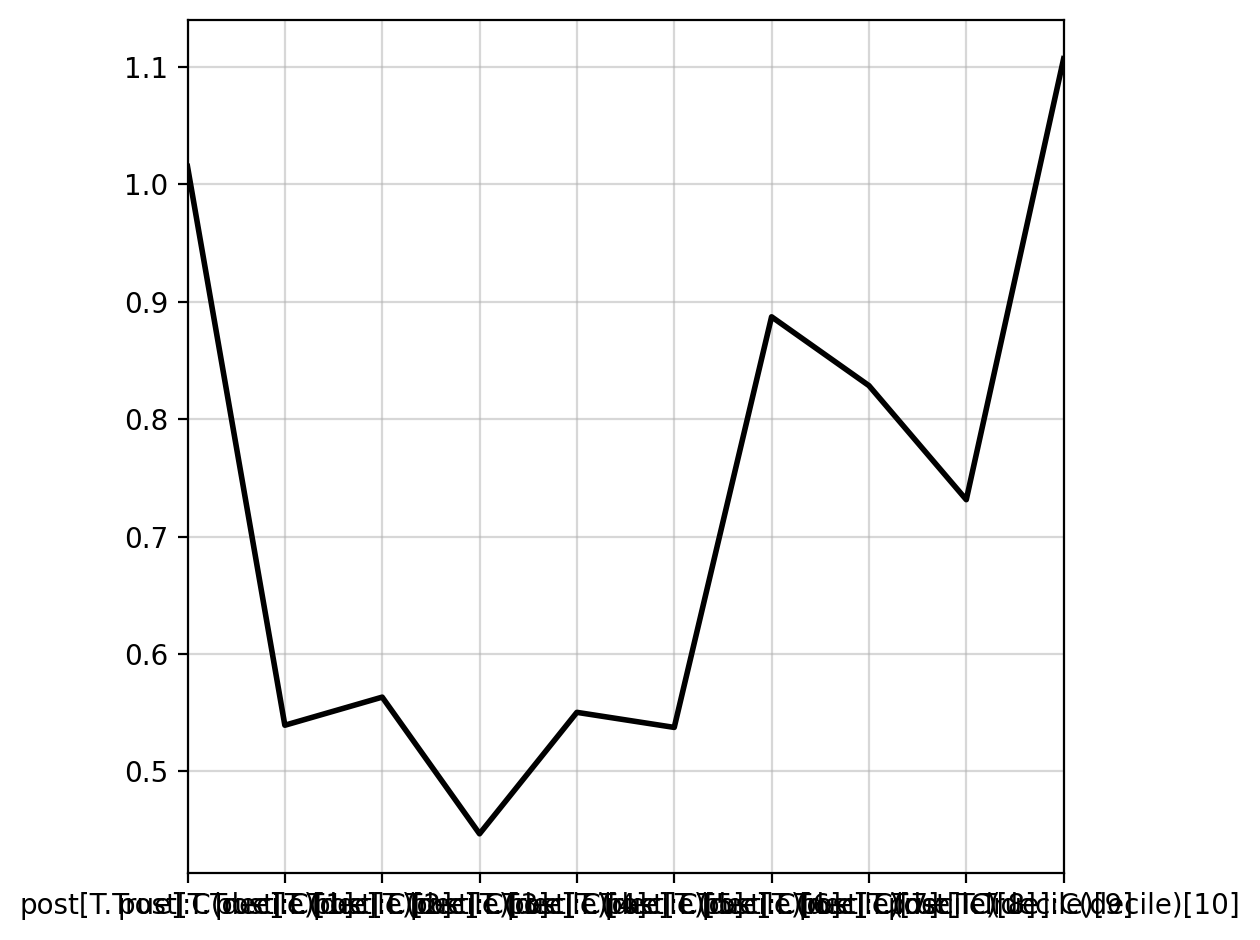

In [40]:
plt.clf()
plt.plot(income_model.params[params] / consumption_model.params[params])
plt.show()

In [41]:
nboot = 2000
dconsumption = np.zeros((nboot, 10))
dincome = np.zeros((nboot, 10))
for boot in np.arange(nboot):
    # matters alot: double vs single resampling of the data
    # something tells me single sampling is correct
    # this is correct because: are matching the samples of the original data 
    # so should be all set 
    data_boot = df.copy().sample(len(data), weights=df['weight'], replace=True, axis=0)
    #data_boot = df.copy().sample(len(data), replace=True, axis=0)

    #consumption_model = smf.wls(consumption_reg, data_boot, weights=data_boot['weight']).fit()
    #consumption_model = smf.glm(consumption_reg, data_boot, freq_weights=data_boot['weight'], missing='drop', family=fam).fit()
    consumption_model = smf.glm(consumption_reg, data_boot, missing='drop', family=fam).fit()
    dconsumption[boot, :] = consumption_model.params[params]

    #income_model = smf.wls(income_reg, data_boot, weights=data_boot['weight']).fit()
    #income_model = smf.glm(income_reg, data_boot, freq_weights=data_boot['weight'],  missing='drop', family=fam).fit()
    income_model = smf.glm(income_reg, data_boot,  missing='drop', family=fam).fit()
    dincome[boot, :] = income_model.params[params]


In [42]:
dincome

array([[-0.33122216, -0.27585931, -0.26729658, ..., -0.32969261,
        -0.32253869, -0.34952542],
       [-0.36764808, -0.29020288, -0.27442405, ..., -0.3356908 ,
        -0.31111171, -0.34432702],
       [-0.31515411, -0.25321196, -0.24868498, ..., -0.30064263,
        -0.32008158, -0.2947754 ],
       ...,
       [-0.30617903, -0.25770752, -0.26046402, ..., -0.31744554,
        -0.33362474, -0.29700987],
       [-0.27492033, -0.26193952, -0.24897884, ..., -0.31499219,
        -0.32130038, -0.28488282],
       [-0.30432458, -0.25451628, -0.24425585, ..., -0.30605792,
        -0.30289056, -0.38448767]])

In [43]:
deciles = np.arange(1, 11)

dconsumption_c10 = [np.quantile(dconsumption[:, ii], 0.10) for ii in np.arange(10)]
dconsumption_c90 = [np.quantile(dconsumption[:, ii], 0.90) for ii in np.arange(10)]
dconsumption_mean = [np.mean(dconsumption[:, ii]) for ii in np.arange(10)]

dincome_c10 = [np.quantile(dincome[:, ii], 0.10) for ii in np.arange(10)]
dincome_c90 = [np.quantile(dincome[:, ii], 0.90) for ii in np.arange(10)]
dincome_mean = [np.mean(dincome[:, ii]) for ii in np.arange(10)]


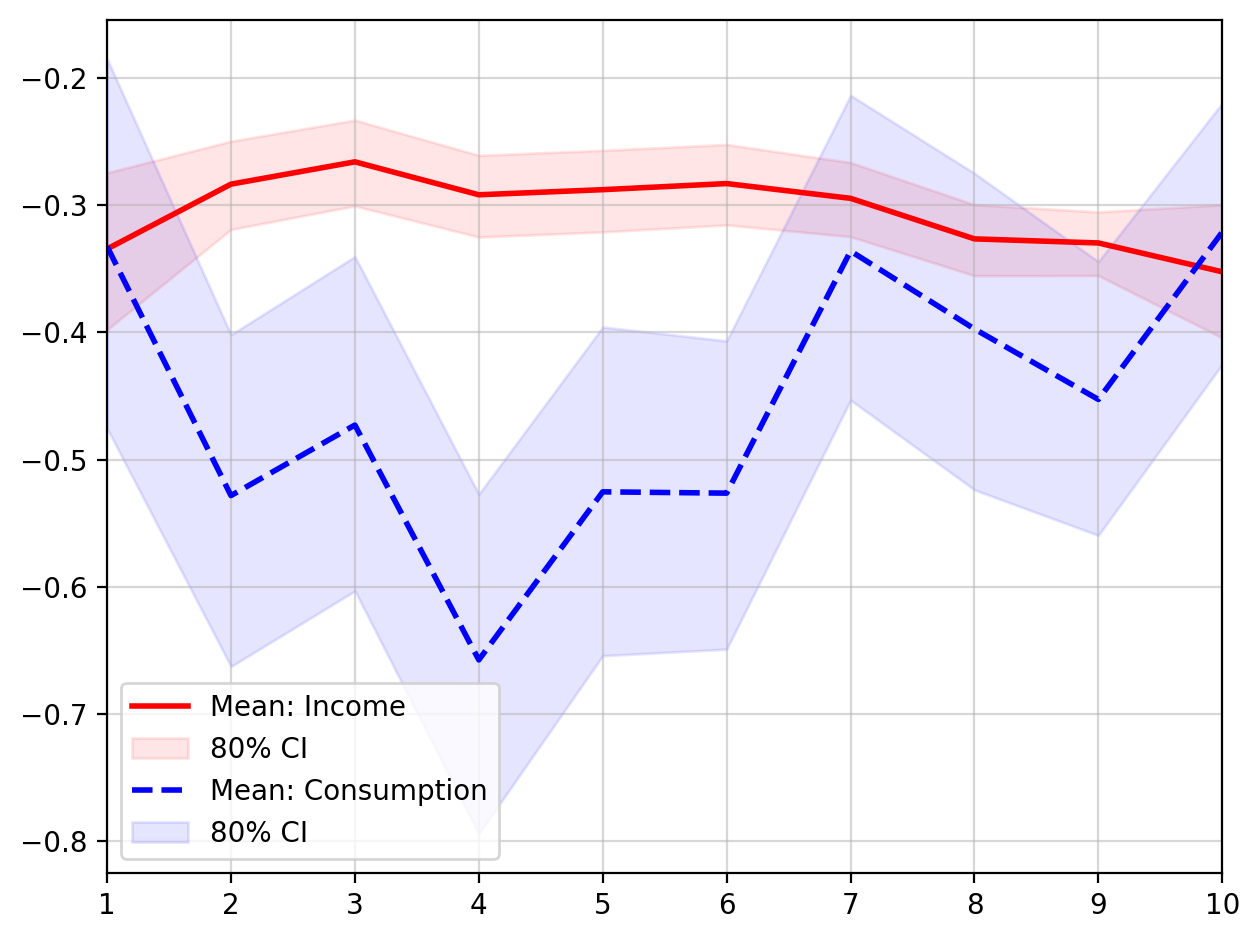

In [44]:
plt.clf()

plt.plot(deciles, dincome_mean, color='red', label='Mean: Income')
plt.fill_between(deciles, dincome_c10, dincome_c90, color='red', alpha=0.10, label='80% CI')

plt.plot(deciles, dconsumption_mean, color='blue', label='Mean: Consumption')
plt.fill_between(deciles, dconsumption_c10, dconsumption_c90, color='blue', alpha=0.10, label='80% CI')

plt.legend()


#plt.gca().set_ylim(top=0)
plt.show()
#plt.plot(dconsumption_c10, label='lower')
#plt.plot(dconsumption_c90, label='upper')

<Figure size 1280x960 with 0 Axes>

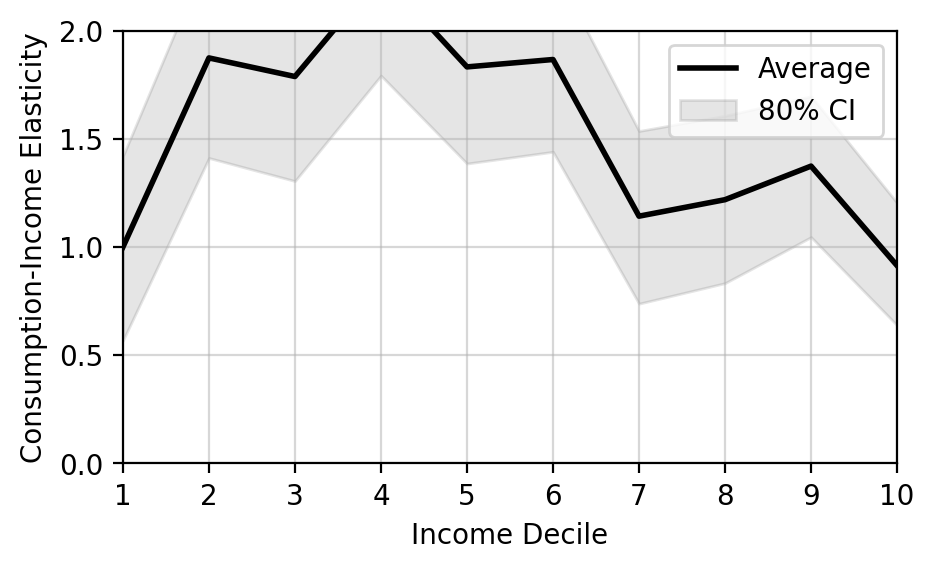

In [45]:
delasticity = dconsumption / dincome

plt.clf()
plt.figure(figsize = mpl.set_size())

delasticity_c10 = [np.quantile(delasticity[:, ii], 0.10) for ii in np.arange(10)]
delasticity_c90 = [np.quantile(delasticity[:, ii], 0.90) for ii in np.arange(10)]
delasticity_mean = [np.mean(delasticity[:, ii]) for ii in np.arange(10)]

plt.plot(deciles, delasticity_mean, label='Average', color='black')
plt.fill_between(deciles, delasticity_c10, delasticity_c90, color='black', alpha=0.10, label='80% CI')
plt.xlabel('Income Decile')
plt.ylim(0, 2.0)
plt.yticks(np.arange(0, 2.50, 0.50))
plt.ylabel('Consumption-Income Elasticity')

plt.legend()

if save:
    os.chdir(plotdir)
#    plt.savefig('elasticity_1994_1996_cugat_withci.png')
plt.show()
    

#plt.gca().set_ylim(top=0)